# Data Understanding
This notebook documents my observations regarding the datasets that will be used to develop the `São Paulo - Atlas` project. With that, we have both layer and geospatially referenced data (with Polygons, Coordinates or some other kind of mapping to location) and raw data files that can be somehow referenced to these locations.

In [1]:
# installing dependencies for data preparation
!pip install -r ../configs/dependencies/dataprep_requirements.txt >> ../configs/dependencies/package_installation.txt

In [2]:
# loading the magic command for the formatter
%load_ext lab_black

In [3]:
###### Loading the necessary libraries #########

# PySpark dependencies:s
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
import pyspark.sql.types as T
from pyspark.sql.window import Window

# Sedona dependencies:
from sedona.utils.adapter import Adapter
from sedona.register import SedonaRegistrator
from sedona.utils import KryoSerializer, SedonaKryoRegistrator
from sedona.core.SpatialRDD import SpatialRDD
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.formatMapper import GeoJsonReader

# database utilities:
from sqlalchemy import create_engine
import sqlite3 as db
import pandas as pd
import geopandas as gpd

# other relevant libraries:
import warnings
import unidecode
import inflection
import unicodedata
from datetime import datetime, timedelta
from functools import partial
import json
import re
import os
from glob import glob
import shutil
import itertools
import chardet

# setting global parameters for visualizationsss:
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# 0. Configuring Spark

In [4]:
# function to encapsulate standard spark configurations:
def init_spark(app_name):

    spark = (
        SparkSession.builder.appName(app_name)
        .config("spark.files.overwrite", "true")
        .config("spark.serializer", KryoSerializer.getName)
        .config("spark.kryo.registrator", SedonaKryoRegistrator.getName)
        .config(
            "spark.jars.packages",
            "org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.1-incubating,"
            "org.datasyslab:geotools-wrapper:geotools-24.1",
        )
        .config("spark.sql.repl.eagerEval.enabled", True)
        .config("spark.sql.repl.eagerEval.maxNumRows", 5)
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY")
        .config("spark.sql.parquet.compression.codec", "gzip")
        .config("sedona.global.charset", "utf8")
        .enableHiveSupport()
        .getOrCreate()
    )

    SedonaRegistrator.registerAll(spark)

    return spark

In [5]:
# init the spark session:
spark = init_spark("SP Atlas - Data Validation")

In [6]:
# verifying the session status:
spark

# 1. Utility Functions

In [7]:
######### Utility Functions #########
# defining a function for better handling of pyspark parquet file outputs:
def save_to_filesystem(df, target_path, parquet_path, filename):
    """Helper function to save pyspark dataframes as parquets in a way that is similar to writing to local files

    Args:
        df (pyspark.sql.dataframe.DataFrame): dataframe to be saved
        target_path (str): path that will store the file
        filename (str): name of the resulting file

    Returns:
        None
    """
    OUTPUT_PATH = f"{target_path}"
    PARQUET_FILE = f"{target_path}/{parquet_path}"
    OUTPUT_FILE = f"{target_path}/{filename}"

    if os.path.exists(PARQUET_FILE):
        print(f"Directory {PARQUET_FILE} already exists, removing it.")
        shutil.rmtree(
            PARQUET_FILE
        )  # if the directory already exists, remove it (throws error if not)

    # saves the dataframe:
    print(
        f"""
    Saving dataframe to {PARQUET_FILE}
    """
    )

    df.coalesce(1).write.save(PARQUET_FILE)

    # retrieves file resulting from the saving procedure:
    original_file = glob(f"{PARQUET_FILE}/*.parquet")[0]
    print(original_file)

    # renames the resulting file and saves it to the target directory:
    print(
        f"""
    Saving
    {original_file} 
    to {OUTPUT_FILE}
    """
    )
    os.rename(original_file, OUTPUT_FILE)

    # deletes the outstanding directory:
    print(
        f"""
    Deleting leftover directory at {PARQUET_FILE}
    """
    )

    shutil.rmtree(PARQUET_FILE)

    return f"Done!"


def save_as_table(df, table_name, database):
    """Helper function to save a pyspark dataframe to sqlite database as a table

    Args:
        df (pyspark.sql.dataframe.DataFrame): dataframe to be written
        table_name (str): name of the table in sqlite
        database (str): path to the target database

    Returns:
        None

    """

    if os.path.exists(database):
        print(f"Database at {database} already exists, connecting to it.")

    else:
        print(f"Database at {database} does not exist, will be created.")

    # instantiating the sqlite database:
    conn = db.connect("../data/database/db_ecommerce.db")

    # converting the pyspark dataframe to pandas:
    pdf = df.toPandas()

    # saving the dataset:
    print(f"Saving dataframe to table {table_name}")
    pdf.to_sql(table_name, conn, if_exists="replace", index=False)

    return "Done!"


def get_file_encoding(filename, is_partial=False):
    if is_partial == True:
        with open(filename, "rb") as input_file:
            start, end = (0, 20000)
            input_file.seek(start)
            print(chardet.detect(input_file.read(end - start)))
    else:
        with open(filename, "rb") as input_file:
            print(chardet.detect(input_file.read()))


def rank_feature(df, col, ascending=True):
    """Helper function to generate rank-based features given a column in PySpark dataframe

    Args:
        df (pyspark.sql.dataframe.DataFrame):
        col (str): the name of the column to be used for calculating the window
        ascending (bool): a boolean indicator as to what type of ranking to be made (ascending or descending)

    """
    # specifying a window function for the operation:
    if ascending:
        window_spec = Window.orderBy(col)
    else:
        window_spec = Window.orderBy(F.desc(col))

    # adding the window function to generate a new column:
    df = df.withColumn(f"score_{col}", F.percent_rank().over(window_spec))

    return df


def bulk_aggregate(df, group_col, aggs, target_cols):
    """Wrapper function to apply multiple aggregations when performing group bys

    It utilizes the spark's SQL Context and string interpolation to perform the aggregation using SQL syntax.

    Args:
        df (pyspark.sql.dataframe.DataFrame): dataframe with raw data
        group_col (str): the column that will be used for grouping
        aggs (list): list of aggregations that want to be made (must be the same name as pyspark.sql.functions)
        target_cols (str): columns in which aggregations will be performed

    Returns:
        df_grouped (pyspark.sql.dataframe.DataFrame): dataframe with the grouped data
    """

    # buils the cartersian product of the lists
    aggs_to_perform = itertools.product(aggs, target_cols)

    Q_LAYOUT = """
    SELECT
        {},
        {}
        FROM df
        GROUP BY {}
    """

    aggregations = []
    for agg, col in aggs_to_perform:

        # builds the string for aggregation
        statement = f"{agg.upper()}({col}) as {agg}_{col}"
        aggregations.append(statement)

    full_statement = ",\n".join(aggregations)

    # uses string interpolation to build the full query statement
    QUERY = Q_LAYOUT.format(group_col, full_statement, group_col)

    # registers the dataframe as temporary table:
    df.registerTempTable("df")
    df_grouped = spark.sql(QUERY)

    # rounds values:
    for column in df_grouped.columns:
        df_grouped = df_grouped.withColumn(column, F.round(F.col(column), 1))

    return df_grouped


def get_null_columns(df, normalize=False):
    """Helper function to print the number of null records for each column of a PySpark DataFrame.

    Args:
        df (pyspark.sql.dataframe.DataFrame): a PySpark Dataframe object

    Returns:
        None -> prints to standard out

    """

    if normalize:
        counts = df.count()

        df_nulls = df.select(
            [
                (F.count(F.when(F.col(column).isNull(), column)) / counts).alias(column)
                for column in df.columns
            ]
        )

    else:
        df_nulls = df.select(
            [
                F.count(F.when(F.col(column).isNull(), column)).alias(column)
                for column in df.columns
            ]
        )

    df_nulls.show(1, truncate=False, vertical=True)


######### Text Processing Functions ########
@udf("string")
def normalize_entities(text):
    """Helper function to normalize text data to ASCII and lower case, removing spaces

    Args:
        text (string): the string that needs to be normalized

    Returns:
        text (string): cleaned up string

    """
    regex = r"[^a-zA-Z0-9,]+"

    if text is not None:

        try:
            text = unicode(text, "utf-8")
        except NameError:
            pass

        text = (
            unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("utf-8")
        )

        text = inflection.underscore(text)
        text = str(text)
        text = text.lower()
        text = re.sub(regex, " ", text)
        text = text.replace(",", ".")
        text = text.replace(".", " ")
        text = text.replace(" ", "_")
        text = text.strip()

    return text


def apply_category_map(category_map):
    """Helper function to convert strings given a map

    Note:
        This function uses the function generator scheme, much like the PySpark code

    Args:
        original_category (str): the original category name
        category_map (dict): the hash table or dictionary for converting the values:

    Returns:
        new_category (str): the resulting category

    """

    def func(row):
        try:
            result = category_map[row]
        except:
            result = None
        return result

    return F.udf(func)


def normalize_column_name(col):
    """Helper function standardize column names

    Args:
        col (str): the column name as a string

    Returns:
        new_col (str): the normalized version of the column name
    """
    # lower case the records
    col = col.lower()

    # replaces spaces for underscores
    col = col.replace(" ", "_")

    # normalizes text to ascii:
    new_col = (
        unicodedata.normalize("NFD", col).encode("ascii", "ignore").decode("utf-8")
    )
    return new_col


######### Feature extraction #######
def get_datetime_features(df, time_col):
    """Function to extract time-based features from pyspark dataframes

    Args:
        df (pyspark.sql.dataframe.DataFrame): the original dataframe that needs to be enriched
        time_col (str): the string name of the column containing the date object

    Returns:
        df (pyspark.sql.dataframe.DataFrame): resulting pyspark dataframe with the added features
            -> See list of attribute the source code for the attributes

    """

    # applying date-related functions:

    # day-level attributes:
    df = df.withColumn("day_of_week", F.dayofweek(F.col(time_col)))

    df = df.withColumn("day_of_month", F.dayofmonth(F.col(time_col)))

    df = df.withColumn("day_of_year", F.dayofyear(F.col(time_col)))

    # week-level attributes:
    df = df.withColumn("week_of_year", F.weekofyear(F.col(time_col)))

    # month-level attributes:
    df = df.withColumn("month", F.month(F.col(time_col)))

    df = df.withColumn("quarter", F.quarter(F.col(time_col)))

    # year-level attributes:
    df = df.withColumn("year", F.year(F.col(time_col)))

    return df

# 2. Inspecting the Data
All the raw datasets for this project are located in the raw data directory for the development environment (`data/raw/`). The layers for geospatial information are located specifically in the `data/raw/sp_layers/` directory.

In [8]:
# listing the folders for the datasets available:
!ls ../data/raw

sp_census  sp_idh	  sp_iptu  sp_layers  sp_real_state_listings
sp_crimes  sp_infocidade  sp_ipvs  sp_rais


In [9]:
# listing the folders for the layers available:
!ls ../data/raw/sp_layers

census_districts     favelas_macro   lights	    squares
census_ponderations  favelas_micro   logradouros    streets
census_sectors	     geologic_risk   metro	    subprefectures
census_subdistricts  health	     neighborhoods  train
culture		     ipvs	     parks	    treelines
demographic_density  irregular_lots  services	    urban_references
education	     land_use	     sports	    zipcodes


# 3. Describing the Datasets
We have several datasets available at our disposal. They represent many factors of sociodemographic and location data that can be converted into usable features for many Machine Learning projects. This project originated while I was working with geospatial data for enhancing Real State price predictions in the city of São Paulo and thus the work here is noticeably oriented towards creating features that might be useful in the Real State setting. 

## 3.0 Units of Interest

When talking about geospatial data for describing features for a machine learning model, we can have several different areas of interest. We might be interested in a **single street** or a whole **neighborhood**. We might also be interested in a block or even the entire city when geospatial data is used in an ample setting (perhaps a whole state or country). The units of relevance for geospatial data in the city of São Paulo can be defined as (from smallest to largest):

1. `sector`: the lowest unit of measurement for the Brazilian Census, which is one of most important geospatially referenced datasets we will be working with;
2. `zipcode`: zip codes in the city of São Paulo can be roughly approximated to an entire street (also called a logradouro);
3. `area_of_ponderation`: areas of ponderation are contiguous groups of census sectors;
4. `neighborhoods`: areas that are often (but not directly) related to the neighborhoods of the city;
5. `districts`: districts are administrative regions defined by law (and thus, won't change much over time), used to allocate resources by the City Hall;

We have layers and geospatially referenced data for all such **Units of Interest** and we will find a way to features at all levels. This is important because allows us to be as specific as possible when needed when it comes to generating features.

## 3.1 IBGE Census
The Brazilian Census is the widest sociodemographic survey conducted by the country. It is done every 10 years and its data is used to develop public policies, adjust the number of representatives per state in the federal government, amongst many other use cases. The most recent census in Brazil was finished in **2010**, so we should keep in mind the age of the data being used. 

Although some features might still be up to date, some might not be as much and this needs to be taken into account. For our purposes, it is still good enough, since the sociodemographic make-up of a region does not change that rapidly and many patterns still exist (rich regions 10 years ago are still rich and poor regions are most likely still poor, given the various crisis that happened during the last decade). 

The Census data is broken up in the several dimensions, which are listed below:

In [10]:
! ls ../data/raw/sp_census/universe_results/

Basico_SP1.csv		Pessoa01_SP1.csv  Pessoa10_SP1.csv
Domicilio01_SP1.csv	Pessoa02_SP1.csv  Pessoa11_SP1.csv
Domicilio02_SP1.csv	Pessoa03_SP1.csv  Pessoa12_SP1.csv
DomicilioRenda_SP1.csv	Pessoa04_SP1.csv  Pessoa13_SP1.csv
Entorno01_SP1.csv	Pessoa05_SP1.csv  PessoaRenda_SP1.csv
Entorno02_SP1.csv	Pessoa06_SP1.csv  Responsavel01_SP1.csv
Entorno03_SP1.csv	Pessoa07_SP1.csv  Responsavel02_SP1.csv
Entorno04_SP1.csv	Pessoa08_SP1.csv  ResponsavelRenda_SP1.csv
Entorno05_SP1.csv	Pessoa09_SP1.csv


These various `.csv` contain many, many features related to sociodemographic attributes of the regions and population where the surveys are conducted. The lowest unit of aggregated data in all of these files is called a `sector`. A sector might be a block of a street, for example. 

The datasets also contain a classification for the `district` in which they take place, which can be roughly approximated into the `neighborhoods` for most cities. This is not the case of **São Paulo**, in which each `district` can contain many different `neighborhoods`. For São Paulo, this poses somewhat of a problem, since many people are confused about the distinction between neighborhoods and districts. 

Before working on **Project Atlas**, I also had no idea of this distinction. Later on, we will need to take this into account, since `districts` can become quite large and might not be always the best unit of aggregation. Similarly, `sectors` can be also prohibitevely small and not a good feature level for a Machine Learning model. We will have to figure out ways to deal with such attributes.

In [11]:
# let's check how the data is encoded:
CENSUS_DATA_DIR = "../data/raw/sp_census/universe_results/"

# retrieving the encoding of one sample file:
get_file_encoding(CENSUS_DATA_DIR + "Basico_SP1.csv", is_partial=True)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [12]:
# loading a sample file:
df_census = pd.read_csv(
    CENSUS_DATA_DIR + "Basico_SP1.csv", encoding="latin_1", sep=";", nrows=10
)

# verifying the data:
df_census.head()

,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V004,V005,V006,V007,V008,V009,V010,V011,V012,Unnamed: 33
0,355030801000001,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"2,32","2091,32","8532451,78","2164,55","8673276,78","1227,41","4285771,99","1713,75","5152087,86",NaN
1,355030801000002,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"2,09","1650,09","3983441,31","1717,44","4030519,99","1045,78","2572133,32","1468,08","2991546,94",NaN
2,355030801000003,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"3,08","1280,43","5474593,06","2349,53","7553913,02","902,97","2735492,52","1786,79","3837674,74",NaN
3,355030801000004,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"2,26","1119,59","3572955,1","1859,13","4567289,5","869,09","2122409,02","1567,41","2735383,24",NaN
4,355030801000005,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"2,35","1416,9","2240207,58","1581,66","2240109,39","917,71","1570047,75","1356,35","1725877,85",NaN


The columns that start with `V` represent coded variables that can better described with the use of a codebook. The Census codebook, already parsed into an easier to manipulate format in file that can be found in `references/data_documentation/ibge/`.

In [13]:
# listing the helper files:s
!ls ../references/documentation/ibge/

feature_seleciton_ibge.csv   ibge_census_codebook.json
feature_seleciton_ibge.xlsx


## 3.2 IPVS

IPVS stands for **Índice Paulista de Vulnerabilidade Social**, which roughly translates to the city's Social Vulnerability Index. This an important sociodemographic KPI that is a measurement of several factor, such as population, income and infrastructure. The full can be found on [this link](http://ivs.ipea.gov.br/index.php/pt/sobre). The lowest level of the index is at the census `sector` level.

In [14]:
# the dataset can be located in the following directory:
!ls ../data/raw/sp_layers/ipvs/

IPVS_2010.cpg  IPVS_2010.prj  IPVS_2010.shp
IPVS_2010.dbf  IPVS_2010.qpj  IPVS_2010.shx


In [15]:
# loading vector layers using Apache Sedona:
LAYER_DIR = "../data/raw/sp_layers/"

# converting to dataframe:
#### Note: 3550308 is the code for the city of São Paulo
df_ipvs = gpd.read_file(LAYER_DIR + "ipvs/")

# # verifying the results for São Paulo:
df_ipvs = df_ipvs[df_ipvs.CD_GEODM == "3550308"].reset_index(drop=True)

In [16]:
# verifying the results for São Paulo:
df_ipvs.head()

,ID,AREA,CD_GEODI,TIPO,CD_GEODM,V1,V2,V3,V4,V5,...,V41,V42,V43,V44,V45,V46,V47,V48,V49,geometry
0,49539,0.04,355030832000072,URBANO,3550308,3550308,São Paulo,800,0,681,...,100.0000,100.0000,100.0000,36944,6886,11209673,101159.00,11152344.00,11253503,"POLYGON ((-46.65592 -23.60665, -46.65591 -23.6..."
1,49540,0.03,355030832000073,URBANO,3550308,3550308,São Paulo,800,0,681,...,100.0000,100.0000,100.0000,36944,6886,11209673,101159.00,11152344.00,11253503,"POLYGON ((-46.65875 -23.60646, -46.65838 -23.6..."
2,49507,0.01,355030832000040,URBANO,3550308,3550308,São Paulo,800,0,681,...,100.0000,100.0000,100.0000,36944,6886,11209673,101159.00,11152344.00,11253503,"POLYGON ((-46.65752 -23.60675, -46.65762 -23.6..."
3,49541,0.01,355030832000074,URBANO,3550308,3550308,São Paulo,800,0,681,...,99.5781,100.0000,100.0000,36944,6886,11209673,101159.00,11152344.00,11253503,"POLYGON ((-46.65913 -23.60685, -46.65875 -23.6..."
4,49542,0.03,355030832000075,URBANO,3550308,3550308,São Paulo,800,0,681,...,100.0000,100.0000,100.0000,36944,6886,11209673,101159.00,11152344.00,11253503,"POLYGON ((-46.66073 -23.60695, -46.66056 -23.6..."


There are some issues with encoding in the dataset that by default can't be changed directly through `sedona`'s dataframe adapter (it does not recognize `latin-1` encodings by default). Given that we have the original Census shapefiles that match the census sector level, that won't be a problem.

Similar to the Census data, we also have coded variables that need to be translated into more readable column names.

In [17]:
# saving the filtered results as a geojson:
df_ipvs.to_file("../data/raw/sp_ipvs/shapefile/geo_ipvs_SP_2010.shp")

## 3.3 IPTU

The IPTU (*imposto predial e territorial urbano*) is the property tax payed by real state property owners in Brazil, either by regular people or companies. The information if publicly released by the City Hall of São Paulo and contains a lot of relevant features about the real state properties, which is the original reason I developed project Atlas. For this project, we will use the most recent publicly available dataset under the original format, which is from `2017`.

In [18]:
# listing the iptu files:
!ls ../data/raw/sp_iptu/

iptu_raw.csv	  iptu_raw_pt2.csv  iptu_raw_pt4.csv
iptu_raw_pt1.csv  iptu_raw_pt3.csv  iptu_raw_pt5.csv


In [19]:
# describing the iptu directory:
IPTU_DATA_DIR = "../data/raw/sp_iptu/"

# verifying the dataset's encoding:
get_file_encoding(IPTU_DATA_DIR + "iptu_raw.csv", is_partial=True)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [20]:
# reading an excerpt of the file:
df_iptu = pd.read_csv(
    IPTU_DATA_DIR + "iptu_raw.csv", encoding="latin-1", sep=";", nrows=10
)

In [21]:
# verifying the schema:
df_iptu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   NUMERO DO CONTRIBUINTE                 10 non-null     object 
 1   ANO DO EXERCICIO                       10 non-null     int64  
 2   NUMERO DA NL                           10 non-null     int64  
 3   DATA DO CADASTRAMENTO                  10 non-null     object 
 4   TIPO DE CONTRIBUINTE 1                 10 non-null     object 
 5   CPF/CNPJ DO CONTRIBUINTE 1             10 non-null     object 
 6   NOME DO CONTRIBUINTE 1                 10 non-null     object 
 7   TIPO DE CONTRIBUINTE 2                 3 non-null      object 
 8   CPF/CNPJ DO CONTRIBUINTE 2             10 non-null     object 
 9   NOME DO CONTRIBUINTE 2                 3 non-null      object 
 10  NUMERO DO CONDOMINIO                   10 non-null     object 
 11  CODLOG DO

For data privacy reasons (the dataset, although public, contains personally identifiable information), I won't display the dataset in this notebook directly, but the schema of the dataset above gives us a sense of how the data is layed out.

## 3.4 IDHM

The IDHM (*índice de desenvolvimento humano municipal*) is a local version of the `HDI` (human development index). It is implemented at the `district` level and thus can only be properly attributed at levels at least larger than districts.

In [22]:
# describing the iptu directory:
IDH_DATA_DIR = "../data/raw/sp_idh/"

# verifying the dataset's encoding:
get_file_encoding(IDH_DATA_DIR + "idh_2010_raw.csv", is_partial=True)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [23]:
# reading an excerpt of the file:
df_idh = pd.read_csv(IDH_DATA_DIR + "idh_2010_raw.csv", encoding="latin-1", nrows=10)

In [24]:
# verifying the results:
df_idh.head()

,COD_ID,NOME_UDH,CODMUN6,NOME_MUN,CODUF,NOME_UF,CODRM,NOME_RM,ANO,ESPVIDA,...,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,CODDIST,DISTRITO,REGIAO8,PREFREG
0,1355030801001,Jardim Anália Franco / Vila Formosa : Hospital...,355030,São Paulo (SP),35,SP,63500,RM São Paulo (SP),2000,76.57,...,0.66,0.80,0.82,0.75,0.86,0.85,85,Vila Formosa,Leste 1,Aricanduva/Formosa/Carrão
1,1355030801002,Vila Califórnia,355030,São Paulo (SP),35,SP,63500,RM São Paulo (SP),2000,76.78,...,0.66,0.74,0.81,0.71,0.86,0.86,20,Carrão,Leste 1,Aricanduva/Formosa/Carrão
2,1355030801003,Vila Carrão / Vila Formosa : Cemitério Vila Fo...,355030,São Paulo (SP),35,SP,63500,RM São Paulo (SP),2000,72.90,...,0.51,0.69,0.71,0.62,0.80,0.72,20,Carrão,Leste 1,Aricanduva/Formosa/Carrão
3,1355030801004,Vila Formosa : Escola Municipal de Ensino Fund...,355030,São Paulo (SP),35,SP,63500,RM São Paulo (SP),2000,74.85,...,0.55,0.71,0.75,0.65,0.83,0.78,85,Vila Formosa,Leste 1,Aricanduva/Formosa/Carrão
4,1355030801005,Aricanduva : Centro de Educação Infantil Coryn...,355030,São Paulo (SP),35,SP,63500,RM São Paulo (SP),2000,75.02,...,0.62,0.67,0.75,0.65,0.83,0.78,4,Aricanduva,Leste 1,Aricanduva/Formosa/Carrão


## 3.5 RAIS

The `RAIS` (Relação Anual de Informações Sociais) is a governmental report aimed at summarizing data related to employment in different sectors of the economy, as well as the size of companies in such sectors. This allows us to generate features about employment rates at certain regions. The dataset is broken up in a few different files, which are listed below:

In [25]:
# listing the RAIS datasets:
!ls ../data/raw/sp_rais/

rais_commerce_services.csv  rais_industry.csv  rais_raw.csv


In [26]:
# RAIS data dir:
RAIS_DATA_DIR = "../data/raw/sp_rais/"

# reading the RAIS main dataset:
df_rais_raw = pd.read_csv(RAIS_DATA_DIR + "rais_raw.csv", encoding="latin_1", sep=",")

In [27]:
# verifying the results:
df_rais_raw.head()

,CHAVEGERAL,AREAP,CODDIST,DISTRITO,CODSUBPREF,SUBPREF,CODREGIAO5,REGIAO5,CODREGIAO8,REGIAO8,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82
0,355030800500178090101,3550308005001,78,SE,09,SE,01,Centro,01,CENTRO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,355030800500178090101,3550308005001,78,SE,09,SE,01,Centro,01,CENTRO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,355030800500178090101,3550308005001,78,SE,09,SE,01,Centro,01,CENTRO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,355030800500178090101,3550308005001,78,SE,09,SE,01,Centro,01,CENTRO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,355030800500178090101,3550308005001,78,SE,09,SE,01,Centro,01,CENTRO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# reading the RAIS commerce dataset:
df_rais_com = pd.read_csv(
    RAIS_DATA_DIR + "rais_commerce_services.csv", encoding="latin_1", sep=";"
)

# visualizing the results:
df_rais_com.head()

,AED_2010,COD_DIST,DISTRITO,COD_SUBPREF,SUBPREF,COD_REG8,REGIAO8,COD_REG5,REGIAO5,N_SETOR,SETOR,ESTAB_MICRO,EMPR_MICRO,ESTAB_PEQ,EMPR_PEQ,ESTAB_MED,EMPR_MED,ESTAB_GDE,EMPR_GDE
0,3550308005001,78,SE,9,SE,1,CENTRO,1,Centro,5 e 6,COMÉRCIO E SERVIÇOS,5.03,16.11,1.18,22.66,103,7.04,85,45.44
1,3550308005002,66,REPUBLICA,9,SE,1,CENTRO,1,Centro,5 e 6,COMÉRCIO E SERVIÇOS,1.26,3.96,297.00,5.91,38,2.62,26,18.10
2,3550308005003,66,REPUBLICA,9,SE,1,CENTRO,1,Centro,5 e 6,COMÉRCIO E SERVIÇOS,4.90,15.47,1.04,20.49,134,9.20,127,53.71
3,3550308005004,9,BOM RETIRO,9,SE,1,CENTRO,1,Centro,5 e 6,COMÉRCIO E SERVIÇOS,2.30,7.56,440.00,8.14,40,2.70,25,12.50
4,3550308005005,10,BRAS,25,MOOCA,2,LESTE 1,2,Leste,5 e 6,COMÉRCIO E SERVIÇOS,3.18,10.69,559.00,10.51,35,2.54,26,13.80


In [29]:
# reading the RAIS commerce dataset:
df_rais_industry = pd.read_csv(
    RAIS_DATA_DIR + "rais_industry.csv", encoding="latin_1", sep=";"
)

# visualizing the results:
df_rais_industry.head()

,AED_2010,COD_DIST,DISTRITO,COD_SUBPREF,SUBPREF,COD_REG8,REGIAO8,COD_REG5,REGIAO5,N_SETOR,SETOR,ESTAB_MICRO,EMPR_MICRO,ESTAB_PEQ,EMPR_PEQ,ESTAB_MED,EMPR_MED,ESTAB_GDE,EMPR_GDE
0,3550308005001,78,SE,9,SE,1,CENTRO,1,Centro,2,IND. TRNSFORMAÇÃO,115.00,722.00,21,671.00,1,400.00,0,0.00
1,3550308005002,66,REPUBLICA,9,SE,1,CENTRO,1,Centro,2,IND. TRNSFORMAÇÃO,58.00,273.00,7,388.00,2,237.00,0,0.00
2,3550308005003,66,REPUBLICA,9,SE,1,CENTRO,1,Centro,2,IND. TRNSFORMAÇÃO,149.00,661.00,15,554.00,2,246.00,0,0.00
3,3550308005004,9,BOM RETIRO,9,SE,1,CENTRO,1,Centro,2,IND. TRNSFORMAÇÃO,1.01,6.11,200,7.46,11,1.83,0,0.00
4,3550308005005,10,BRAS,25,MOOCA,2,LESTE 1,2,Leste,2,IND. TRNSFORMAÇÃO,1.07,5.92,114,4.46,7,1.45,0,0.00


## 3.6 GeoSampa Layers

The [GeoSampa website]() provides access to many geospatial layers, from which some represent our previously defined `units of interest` as well as many others more specific topics, such as *areas of geologic risk*, *location of slums*, *demographic density* and much more. There will be used to generate features at the available levels when applicable (for example, it doesn't make sense to denote if a park is located on a census sector).

In [35]:
!ls ../data/raw/sp_layers/

census_districts     favelas_macro   lights	    squares
census_ponderations  favelas_micro   logradouros    streets
census_sectors	     geologic_risk   metro	    subprefectures
census_subdistricts  health	     neighborhoods  train
culture		     ipvs	     parks	    treelines
demographic_density  irregular_lots  services	    urban_references
education	     land_use	     sports	    zipcodes


In [86]:
# loading a sample layer:
LAYERS_DATA_DIR = "../data/raw/sp_layers/"

df_favelas = gpd.read_file(LAYERS_DATA_DIR + "favelas_macro/")

In [88]:
# it looks like the geometry of this shapefile is at a different projection (we need to convert it to WGS84 Latitude/Longitude: "EPSG:4326")
df_favelas.head()

,ID,AREA_m²,NOME,DATULTATZ,ENDERECO,NOMESEC,PROPRTR,geometry
0,1,23687,Parque Figueira Grande II,2011-07-04,Rua Domingos Furtado / Rua Pedro Agulha de Fig...,Piraporinha I / Parque Figueira Grande,Municipal,"MULTIPOLYGON (((321800.103 7379805.011, 321793..."
1,2,404,Vila Clara,2011-06-16,Rua Constantino Cavafi,None,Municipal,"POLYGON ((333166.232 7381209.623, 333172.365 7..."
2,3,486,Pedro Bueno,2012-04-18,Avenida Pedro Bueno,None,Municipal,"POLYGON ((332055.718 7385514.846, 332035.292 7..."
3,4,453,Tolstoi II,2011-01-19,Avenida Professor Luis Ignácio de Anhaia Mello...,None,None,"POLYGON ((344554.144 7389067.211, 344525.247 7..."
4,5,20843,Vila Cheba,2011-08-11,R Júlio de Barros /R. Justino Nigro,Justino Nigro / Jardim Régis,Municipal,"POLYGON ((327738.261 7377022.274, 327768.795 7..."


In [89]:
# loading the layer with train locations:
df_trains = gpd.read_file(LAYERS_DATA_DIR + "train/")

# verifying the favelas layers:
df_trains.head()

,etr_situac,etr_linha,etr_nome,etr_empres,geometry
0,OPERANDO,DIAMANTE,PARADA AMADOR BUENO,CPTM,POINT (297477.101 7396351.054)
1,OPERANDO,RUBI,JUNDIAÍ,CPTM,POINT (308378.796 7433640.756)
2,OPERANDO,ESMERALDA,PRIMAVERA-INTERLAGOS,CPTM,POINT (327545.649 7375448.035)
3,OPERANDO,ESMERALDA,GRAJAÚ,CPTM,POINT (327027.861 7373920.436)
4,OPERANDO,TURQUESA,PREFEITO CELSO DANIEL-SANTO ANDRÉ,CPTM,POINT (344127.852 7383458.049)


# 4. Units of Interest Layers

## 4.1 Census Sectors

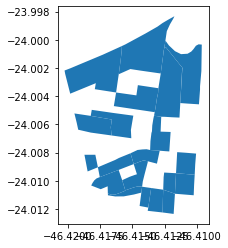

In [92]:
# verifying the census sector layer:
census_sectors = gpd.read_file(LAYERS_DATA_DIR + "census_sectors/")

# plotting some results:
census_sectors.head(20).plot()

In [40]:
# looking up some of the data:
census_sectors.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
0,98237.00,354100005000009,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,1,"POLYGON ((-46.41024 -24.01103, -46.41169 -24.0..."
1,98232.00,354100005000004,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,2,"POLYGON ((-46.41606 -24.00245, -46.41598 -24.0..."
2,98230.00,354100005000002,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,3,"POLYGON ((-46.41213 -24.00792, -46.41244 -24.0..."
3,98229.00,354100005000001,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,4,"POLYGON ((-46.41134 -24.00552, -46.41196 -24.0..."
4,98231.00,354100005000003,URBANO,35410000500,None,354100005,PRAIA GRANDE,3541000,PRAIA GRANDE,SANTOS,METROPOLITANA DE SÃO PAULO,354100005001,Boqueirão,5,"POLYGON ((-46.41326 -24.00514, -46.41484 -24.0..."


## 4.2 Areas of Ponderation

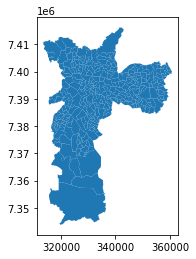

In [93]:
# verifying the census ponderations layer:
census_ap = gpd.read_file(LAYERS_DATA_DIR + "census_ponderations/")

# plotting some results:
census_ap.plot()

## 4.3 Neighborhoods

In [52]:
# verifying the neighborhoods:
neighborhoods = gpd.read_file(LAYERS_DATA_DIR + "neighborhoods/")

# changing column names:
neighborhoods = neighborhoods.rename(columns={"Name": "neighborhood"}).drop(
    columns=["descriptio"]
)

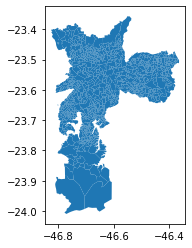

In [94]:
# plotting the subdistrictics:
neighborhoods.plot()

In [54]:
# verifying some of the data:
neighborhoods.head()

,neighborhood,geometry
0,Alto da Riviera,"MULTIPOLYGON (((-46.75277 -23.71631, -46.75359..."
1,Alto da Mooca,"POLYGON ((-46.58905 -23.56842, -46.58806 -23.5..."
2,Alto da Lapa,"POLYGON ((-46.71966 -23.53703, -46.72026 -23.5..."
3,Vila Agua Funda,"POLYGON ((-46.62985 -23.62920, -46.62805 -23.6..."
4,Agua Fria,"POLYGON ((-46.62296 -23.48182, -46.62217 -23.4..."


## 4.4 Zip Codes
The zip codes in the city of São Paulo can be roughly approximated to a single street. With that, some streets are longer than others and can cross multiple sectors, neighborhoods, et cetera. This can lead to a few problems when trying to summarize data at the zip code level. We can simplify the representation of the zip codes to the center of the line they represent. The dataset we will be working with already does this kind of interpolation.

In [57]:
# listing the datasets:
!ls ../data/raw/sp_layers/zipcodes/

tb_cep_bairro.parquet	     tb_cep_estado.parquet
tb_cep_cidade_faixa.parquet  tb_cep_log_complemento.parquet
tb_cep_cidade.parquet	     tb_cep_log_grande_usuario.parquet
tb_cep_distrito.parquet      tb_cep_logradouro.parquet
tb_cep_estado_faixa.parquet


In [60]:
# loading the street-level file:
df_zip = pd.read_parquet(LAYERS_DATA_DIR + "zipcodes/tb_cep_logradouro.parquet")

In [61]:
# verifying the data integrity:
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245459 entries, 0 to 1245458
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   cep                         1245459 non-null  object 
 1   tipo                        1245459 non-null  object 
 2   nome_logradouro             1245459 non-null  object 
 3   logradouro                  1245459 non-null  object 
 4   bairro_id                   1245459 non-null  object 
 5   distrito_id                 1245459 non-null  object 
 6   cidade_id                   1245459 non-null  int64  
 7   estado                      1245459 non-null  object 
 8   tipo_sem_acento             1245459 non-null  object 
 9   nome_logradouro_sem_acento  1245459 non-null  object 
 10  logradouro_sem_acento       1245459 non-null  object 
 11  latitude                    1245459 non-null  float64
 12  longitude                   1245459 non-null  float64
 1

In [62]:
# visualizing the results:
df_zip.head()

,cep,tipo,nome_logradouro,logradouro,bairro_id,distrito_id,cidade_id,estado,tipo_sem_acento,nome_logradouro_sem_acento,logradouro_sem_acento,latitude,longitude,cep_ativo
0,01001000,Praça,da Sé,Praça da Sé,1,,1,SP,Praca,da Se,Praca da Se,-23.55,-46.63,S
1,01001001,Praça,da Sé,Praça da Sé,1,,1,SP,Praca,da Se,Praca da Se,-23.55,-46.63,S
2,01001010,Rua,Filipe de Oliveira,Rua Filipe de Oliveira,1,,1,SP,Rua,Filipe de Oliveira,Rua Filipe de Oliveira,-23.55,-46.63,S
3,01001900,Praça,da Sé 108,Praça da Sé 108,1,,1,SP,Praca,da Se 108,Praca da Se 108,-23.55,-46.63,S
4,01001901,Praça,da Sé 371,Praça da Sé 371,1,,1,SP,Praca,da Se 371,Praca da Se 371,-23.55,-46.63,S


## 4.5 Districts

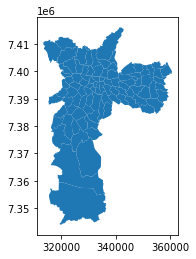

In [95]:
# reading the district files:
df_districts = gpd.read_file(LAYERS_DATA_DIR + "districts/")

# plotting the data:
df_districts.plot()

In [73]:
# need to convert the districts to a different projection as well:
df_districts.head()

,CLASSID,FEATID,REVISIONNU,NOME_DIST,SIGLA_DIST,COD_DIST,COD_SUB,DATA_CRIAC,USUARIO_ID,geometry
0,4.00,8583485.00,1.00,JOSE BONIFACIO,JBO,47,27,2007-03-19,0.00,"POLYGON ((352436.869 7394174.148, 352450.740 7..."
1,4.00,8583484.00,1.00,JD SAO LUIS,JDS,46,18,2007-03-19,0.00,"POLYGON ((320696.639 7383620.282, 320699.486 7..."
2,4.00,8583445.00,1.00,ARTUR ALVIM,AAL,5,21,2007-03-19,0.00,"POLYGON ((349461.276 7397764.525, 349461.935 7..."
3,4.00,8583479.00,1.00,JAGUARA,JAG,40,08,2007-03-19,0.00,"POLYGON ((320731.080 7400614.592, 320732.386 7..."
4,4.00,8583437.00,1.00,VILA PRUDENTE,VPR,93,29,2007-03-19,0.00,"POLYGON ((338651.039 7392203.484, 338654.034 7..."
